In [2]:
import cv2
import torch
import os
from typing import Any
import torch
from torch import Tensor
from torch import nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import time
import copy
import tqdm
import torchvision.transforms as transforms
from torchmetrics.classification import MultilabelAccuracy, Accuracy
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

In [3]:
#######################################데이터관련 로드, 검증, 클래스정의, 데이터로더 #####################
#######################################데이터관련 로드, 검증, 클래스정의, 데이터로더 #####################
#######################################데이터관련 로드, 검증, 클래스정의, 데이터로더 #####################
#image broken check
def check_jpeg_eoi(file_path):
    with open(file_path, 'rb') as f:
        f.seek(-2, 2) # 파일의 끝에서 두 바이트 전으로 이동합니다.
        return f.read() == b'\xff\xd9'


def is_image_valid(image_path):
    try:
        img = Image.open(image_path) # 이미지를 열어봅니다.
        img.verify() # verify() 메소드는 파일이 손상되었는지 확인합니다.
        return True
    except (IOError, SyntaxError) as e:
        print('Invalid image: ', image_path, '\n'+ e) # 손상된 이미지에 대한 에러 메시지를 출력합니다.
        return False

#image validation(exist and broken file)
def validate_dataset(df, img_dir):
    count = 0
    df_bar = tqdm.tqdm(df.itertuples(), desc="validating all images", total=len(df))
    for rows in df_bar:
        if os.path.isfile(img_dir+'/'+ rows.id):
            if is_image_valid(img_dir+'/'+ rows.id) and check_jpeg_eoi(img_dir+'/'+ rows.id):
                continue
            else:
                count += 1
                df.drop(df[df['id'] == rows.id].index, inplace=True)
        else:
            count += 1
            df.drop(df[df['id'] == rows.id].index, inplace=True)
        print("Not founded images (Num) : ",count)
    return df

#csv에서 데이터 가져옴
def get_data_from_csv(csv_path, train_ratio, img_dir, randoms_state=42, val_csv_path=None):
    ###### columns example : ['id', 'good', 'b_edge', 'burr', 'borken', 'b_bubble', 'etc', 'no_lens']
    val_csv_path = None if val_csv_path == 'None' else val_csv_path
    if val_csv_path is not None:
        train_df = pd.read_csv(csv_path)
        train_df = validate_dataset(df=train_df, img_dir=img_dir)
        val_df = pd.read_csv(val_csv_path)
        val_df = validate_dataset(df=val_df, img_dir=img_dir)
    else:
        df = pd.read_csv(csv_path)
        df = validate_dataset(df=df,img_dir=img_dir)
        train_df , val_df = train_test_split(df, test_size=train_ratio, random_state=randoms_state)

    print('num of train_df',len(train_df))
    print('num of val_df',len(val_df))

    num_cls = len(train_df.columns) - 1  # because, it is multi-label

    print('number of class: ', num_cls)
    cls_list = list(train_df.columns)
    cls_list.remove('id')
    print(cls_list)
    
    return train_df, val_df, num_cls, cls_list

class CustomDataset(Dataset):

    def __init__(self, dataframe, image_dir, num_classes, class_list, transforms=None, img_resize = False, img_dsize = (640,640), polar_tranform = False):
        super().__init__()
        
        self.image_ids = dataframe['id'].unique() # 이미지 고유 ID
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.img_resize = img_resize
        self.img_dsize = img_dsize
        self.class_list = class_list
        self.num_classes = num_classes
        self.polar_transform = polar_tranform

    #데이터 길이 검증
    def validate_data_records(self):
        for idx, image_id in enumerate(self.image_ids):
            records = self.df[self.df['id'] == image_id]
            target = np.array(records[self.class_list].values).astype(np.float32)
            if target.shape[1] != len(self.class_list):
                print(f"Index {idx} with image_id {image_id} has mismatched target size. Expected {len(self.class_list)}, but got {target.shape[1]}")

    def polar_transform_func(self, pic):
        pic = cv2.linearPolar(pic, (pic.shape[0]/2,pic.shape[1]/2), pic.shape[0]/2, cv2.WARP_FILL_OUTLIERS)
        pic = cv2.rotate(pic, cv2.ROTATE_90_COUNTERCLOCKWISE)
        img_edge = pic[:160,:,:]
        return img_edge

    def __getitem__(self, index: int):
        # 이미지 index로 아이템 불러오기

        image_id = self.image_ids[index]
        records = self.df[self.df['id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
            
        # OpenCV가 컬러를 저장하는 방식인 BGR을 RGB로 변환
        if self.img_resize and not self.polar_transform:
            image = cv2.resize(image, self.img_dsize)

        if self.polar_transform:
            image = self.polar_transform_func(image)
            if self.img_resize:
                new_width = self.img_dsize[0]
                new_height = int(image.shape[0] * (new_width / image.shape[1]))
                image = cv2.resize(image, (new_width, new_height))
                

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0 # 0 ~ 1로 스케일링

        target = np.array(records[self.class_list].values).astype(np.float32)
        target = target.reshape(-1)
        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, 0)

    # Find the maximum target length
    max_len = max([len(t) for t in targets])

    # Pad each target to the maximum length
    targets_padded = [torch.cat([torch.tensor(t), torch.zeros(max_len - len(t))]) for t in targets]

    targets = torch.stack(targets_padded, 0)
    return images, targets

In [4]:
import sys
sys.path.append('../')

# #모델구조
from polar import *
from googlenetv4 import *

In [5]:
#####################기타####################
def create_directory(save_path):
    i = 1
    while True:
        dir_name = os.path.join('models/'+save_path+ str(i) +'/')
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
            os.makedirs(dir_name+'/result')
            return dir_name
            break
        i += 1

In [6]:
########################################## 학습 매커니즘 설정 #####################################
########################################## 학습 매커니즘 설정 #####################################
########################################## 학습 매커니즘 설정 #####################################

# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# function to start training
def train_val(model, device, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}
    metric_cls_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())


    for epoch in range(num_epochs):
        start_time = time.time()
        current_lr = get_lr(opt)

        print(f"Epoch {epoch}/{num_epochs-1}")

        model.train()
        train_loss, train_metric,train_cls_metric = loss_epoch_multi_output(model, device, loss_func, train_dl, sanity_check, opt)

        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric.item())

        metric_cls_history['train'].append(train_cls_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric,val_cls_metric = loss_epoch_multi_output(model, device, loss_func, val_dl, sanity_check)

        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric.item())

        metric_cls_history['val'].append(val_cls_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if isinstance(model, torch.nn.DataParallel):
        # model.module is the original model before DataParallel
            torch.save(model.module.state_dict(), path2weights + f'{epoch}_weight.pt')
        else:
            torch.save(model.state_dict(), path2weights + f'{epoch}_weight.pt')

        # torch.save(model.module.state_dict(), path2weights + f'{epoch}_weight.pt')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print(f'train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {val_metric:.2f},cls_acc : {val_cls_metric}, time: {(time.time()-start_time)/60:.4f} min')
        lossdf = pd.DataFrame(loss_history)
        accdf = pd.DataFrame(metric_history)
        acc_clsdf = pd.DataFrame(metric_cls_history)

        lossdf.to_csv(path2weights + 'result/loss.csv')
        accdf.to_csv(path2weights + 'result/acc.csv')
        acc_clsdf.to_csv(path2weights + 'result/cls_acc.csv')


    # model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history, metric_cls_history

def metric_batch_multi_output(output, target, device):
    # output: [batch_size, num_classes], target: [batch_size, num_classes]

    pred = output.sigmoid() >= 0.5

    num_classes = target.shape[1]
    mla_ova = MultilabelAccuracy(num_labels=num_classes).to(device=device)
    mla = MultilabelAccuracy(num_labels=num_classes, average=None).to(device=device)

    class_accuracies = mla(pred, target)
    overall_accuracy = mla_ova(pred, target)

    return class_accuracies, overall_accuracy


def loss_batch_multi_output(loss_func, output, target, device, opt=None):
    # output: [batch_size, num_classes], target: [batch_size, num_classes]
    loss_b = loss_func(output, target)
    class_metric_b , metric_b = metric_batch_multi_output(output, target, device)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b, class_metric_b

def loss_epoch_multi_output(model, device, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    running_class_metrics = torch.zeros(dataset_dl.dataset.num_classes).to(device)
    len_data = len(dataset_dl.dataset)
    num_classes = dataset_dl.dataset.num_classes
    b_count = 0
    with tqdm.tqdm(dataset_dl, unit="batch") as tepoch:
        for xb, yb in tepoch:
            b_count+=1
            xb = xb.to(device)
            yb = yb.to(device)
            output = model(xb)

            loss_b, metric_b, class_metric_b = loss_batch_multi_output(loss_func, output, yb, device, opt)

            running_loss += loss_b

            if metric_b is not None:
                running_metric += metric_b

            if class_metric_b is not None:
                running_class_metrics += class_metric_b

            if sanity_check is True:
                break

    loss = running_loss / b_count
    metric = running_metric / b_count # 수정된 부분
    class_metrics = {f'class_{i+1}': (running_class_metrics[i] / b_count).item() for i in range(num_classes)}
    return loss, metric, class_metrics

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except os.OSerror:
        print('Error')
createFolder('./models')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
print(device)

cuda


In [14]:
model = CNN_GRU_Model(num_classes=2)
model.load_state_dict(torch.load('models/polarGRU_2/31_weight.pt'))

################## gpu사용처리 ######################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
num_device = torch.cuda.device_count()
print(device)

model_origin = model.to(device=device)



FileNotFoundError: [Errno 2] No such file or directory: 'models/polarGRU_2/31_weight.pt'

In [8]:
csv_path = '../csvs/polar.csv'
img_dir = '../data/polar/'

IMG_SIZE = 1000
BATCH_SIZE = 128

In [9]:
train_df, val_df, NUM_CLS, cls_list = get_data_from_csv(csv_path=csv_path,img_dir=img_dir, train_ratio=0.2, randoms_state=43, val_csv_path='None')
transformation = transforms.Compose([
                    transforms.ToTensor(),
    ])

train_set = CustomDataset(train_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list ,img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE), polar_tranform=True)
train_set.transforms = transformation

val_set = CustomDataset(val_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE), polar_tranform=True)
val_set.transforms = transformation

test_loader = DataLoader(val_set, batch_size=BATCH_SIZE, collate_fn=collate_fn)

validating all images: 100%|██████████| 707/707 [00:10<00:00, 66.11it/s] 


num of train_df 565
num of val_df 142
number of class:  2
['good', 'defect']


In [48]:
origin_result = []
actual = []

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        output = model(xb)

    _, pred = torch.max(output, 1)

    origin_result.extend(pred.detach().cpu().numpy())  # tensor를 numpy 배열로 변환
    actual.extend(yb.detach().cpu().numpy())
    
    # 메모리 해제
    del xb, yb, output, pred
    torch.cuda.empty_cache()  # 캐시된 메모리 해제


In [49]:
print(origin_result)
actual = [int(x[1] > 0.5) for x in actual]
print(actual)

[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]
[1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


Precision: 0.90141
Recall: 0.90141
F1 Score: 0.90141
Accuracy: 0.90141


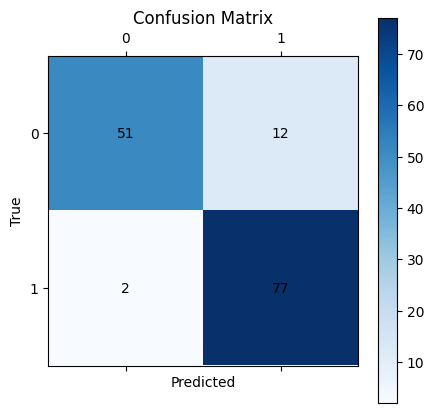

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# 성능 지표 계산
precision = precision_score(actual, origin_result, average='micro')
recall = recall_score(actual, origin_result, average='micro')
f1 = f1_score(actual, origin_result, average='micro')
accuracy = accuracy_score(actual, origin_result)

# 결과 출력
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(np.array(actual).ravel(), np.array(origin_result).ravel())

fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', va='center', ha='center')

plt.show()


In [10]:

IMG_SIZE = 320
BATCH_SIZE = 16

train_df, val_df, NUM_CLS, cls_list = get_data_from_csv(csv_path=csv_path,img_dir=img_dir, train_ratio=0.2, randoms_state=43, val_csv_path='None')
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(IMG_SIZE)
])

train_set = CustomDataset(train_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list ,img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
train_set.transforms = transformation

val_set = CustomDataset(val_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
val_set.transforms = transformation

test_loader = DataLoader(val_set, batch_size=BATCH_SIZE, collate_fn=collate_fn)

validating all images: 100%|██████████| 707/707 [00:00<00:00, 7684.90it/s]

num of train_df 565
num of val_df 142
number of class:  2
['good', 'defect']


In [24]:
model = InceptionV4(num_classes=2)
# model.load_state_dict(torch.load('../models/polar_gnet_1/24_weight.pt'))
model.load_state_dict(torch.load('../models/polar_googlenet_8/16_weight.pt'))
################## gpu사용처리 ######################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
num_device = torch.cuda.device_count()
print(device)

model_origin = model.to(device=device)



cuda


In [25]:
origin_result = []
actual = []

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        output = model(xb)

    _, pred = torch.max(output, 1)

    origin_result.extend(pred.detach().cpu().numpy())  # tensor를 numpy 배열로 변환
    actual.extend(yb.detach().cpu().numpy())
    
    # 메모리 해제
    del xb, yb, output, pred
    torch.cuda.empty_cache()  # 캐시된 메모리 해제

print(origin_result)
actual = [int(x[1] > 0.5) for x in actual]
print(actual)

[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]
[1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


Precision: 0.78169
Recall: 0.78169
F1 Score: 0.78169
Accuracy: 0.78169


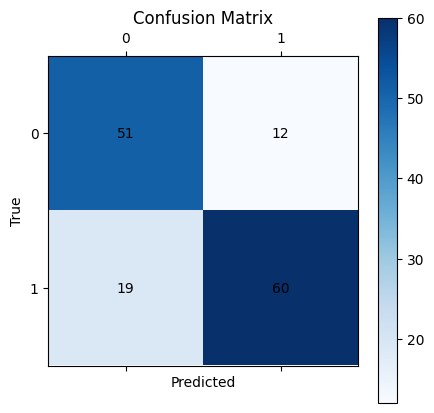

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# 성능 지표 계산
precision = precision_score(actual, origin_result, average='micro')
recall = recall_score(actual, origin_result, average='micro')
f1 = f1_score(actual, origin_result, average='micro')
accuracy = accuracy_score(actual, origin_result)

# 결과 출력
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(np.array(actual).ravel(), np.array(origin_result).ravel())

fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', va='center', ha='center')

plt.show()



In [29]:
model = InceptionV4(num_classes=2)
# model.load_state_dict(torch.load('../models/polar_gnet_1/24_weight.pt'))
model.load_state_dict(torch.load('../models/polar_googlenet_11/3_weight.pt'))
################## gpu사용처리 ######################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
num_device = torch.cuda.device_count()
print(device)

model_origin = model.to(device=device)
origin_result = []
actual = []

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        output = model(xb)

    _, pred = torch.max(output, 1)

    origin_result.extend(pred.detach().cpu().numpy())  # tensor를 numpy 배열로 변환
    actual.extend(yb.detach().cpu().numpy())
    
    # 메모리 해제
    del xb, yb, output, pred
    torch.cuda.empty_cache()  # 캐시된 메모리 해제

print(origin_result)
actual = [int(x[1] > 0.5) for x in actual]
print(actual)

cuda
[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]
[1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


Precision: 0.82394
Recall: 0.82394
F1 Score: 0.82394
Accuracy: 0.82394


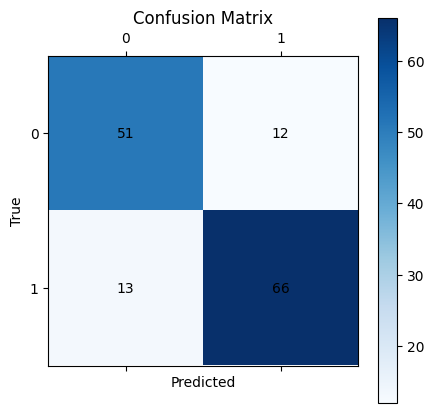

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# 성능 지표 계산
precision = precision_score(actual, origin_result, average='micro')
recall = recall_score(actual, origin_result, average='micro')
f1 = f1_score(actual, origin_result, average='micro')
accuracy = accuracy_score(actual, origin_result)

# 결과 출력
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(np.array(actual).ravel(), np.array(origin_result).ravel())

fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', va='center', ha='center')

plt.show()



In [24]:
IMG_SIZE = 640
BATCH_SIZE = 16

train_df, val_df, NUM_CLS, cls_list = get_data_from_csv(csv_path=csv_path,img_dir=img_dir, train_ratio=0.2, randoms_state=43, val_csv_path='None')
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(IMG_SIZE)
])

train_set = CustomDataset(train_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list ,img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
train_set.transforms = transformation

val_set = CustomDataset(val_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
val_set.transforms = transformation

test_loader = DataLoader(val_set, batch_size=BATCH_SIZE, collate_fn=collate_fn)

from efficientnet import EfficientNet
model = EfficientNet.from_name('efficientnet-b8', num_classes = 2)

# model.load_state_dict(torch.load('../models/polar_gnet_1/24_weight.pt'))
model.load_state_dict(torch.load('../models/polar_effinet_3/30_weight.pt'))
################## gpu사용처리 ######################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
num_device = torch.cuda.device_count()
print(device)

model_origin = model.to(device=device)
origin_result = []
actual = []

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        output = model(xb)

    _, pred = torch.max(output, 1)

    origin_result.extend(pred.detach().cpu().numpy())  # tensor를 numpy 배열로 변환
    actual.extend(yb.detach().cpu().numpy())
    
    # 메모리 해제
    del xb, yb, output, pred
    torch.cuda.empty_cache()  # 캐시된 메모리 해제

print(origin_result)
actual = [int(x[1] > 0.5) for x in actual]
print(actual)

validating all images: 100%|██████████| 707/707 [00:00<00:00, 6546.37it/s]


num of train_df 565
num of val_df 142
number of class:  2
['good', 'defect']
cuda
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


Precision: 0.57746
Recall: 0.57746
F1 Score: 0.57746
Accuracy: 0.57746


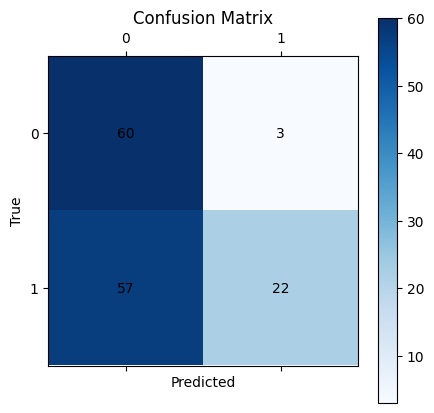

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# 성능 지표 계산
precision = precision_score(actual, origin_result, average='micro')
recall = recall_score(actual, origin_result, average='micro')
f1 = f1_score(actual, origin_result, average='micro')
accuracy = accuracy_score(actual, origin_result)

# 결과 출력
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(np.array(actual).ravel(), np.array(origin_result).ravel())

fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', va='center', ha='center')

plt.show()



In [26]:
IMG_SIZE = 640
BATCH_SIZE = 16

train_df, val_df, NUM_CLS, cls_list = get_data_from_csv(csv_path=csv_path,img_dir=img_dir, train_ratio=0.2, randoms_state=43, val_csv_path='None')
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(IMG_SIZE)
])

train_set = CustomDataset(train_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list ,img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
train_set.transforms = transformation

val_set = CustomDataset(val_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
val_set.transforms = transformation

test_loader = DataLoader(val_set, batch_size=BATCH_SIZE, collate_fn=collate_fn)

from ViT import ViT
model = ViT(num_classes=NUM_CLS, img_size=640)

# model.load_state_dict(torch.load('../models/polar_gnet_1/24_weight.pt'))
model.load_state_dict(torch.load('../models/polar_vit_1/139_weight.pt'))
################## gpu사용처리 ######################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
num_device = torch.cuda.device_count()
print(device)

model_origin = model.to(device=device)
origin_result = []
actual = []

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        output = model(xb)

    _, pred = torch.max(output, 1)

    origin_result.extend(pred.detach().cpu().numpy())  # tensor를 numpy 배열로 변환
    actual.extend(yb.detach().cpu().numpy())
    
    # 메모리 해제
    del xb, yb, output, pred
    torch.cuda.empty_cache()  # 캐시된 메모리 해제

print(origin_result)
actual = [int(x[1] > 0.5) for x in actual]
print(actual)

validating all images: 100%|██████████| 707/707 [00:00<00:00, 8623.80it/s]


num of train_df 565
num of val_df 142
number of class:  2
['good', 'defect']
cuda
[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
[1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


Precision: 0.92958
Recall: 0.92958
F1 Score: 0.92958
Accuracy: 0.92958


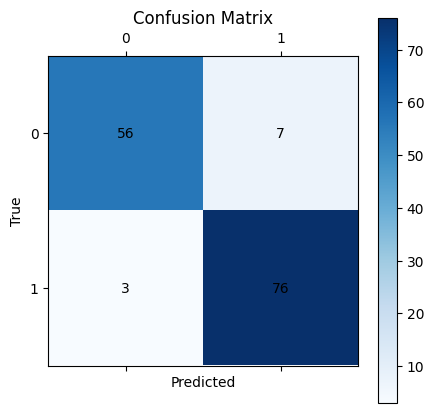

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# 성능 지표 계산
precision = precision_score(actual, origin_result, average='micro')
recall = recall_score(actual, origin_result, average='micro')
f1 = f1_score(actual, origin_result, average='micro')
accuracy = accuracy_score(actual, origin_result)

# 결과 출력
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(np.array(actual).ravel(), np.array(origin_result).ravel())

fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', va='center', ha='center')

plt.show()



In [28]:
IMG_SIZE = 1024
BATCH_SIZE = 16

train_df, val_df, NUM_CLS, cls_list = get_data_from_csv(csv_path=csv_path,img_dir=img_dir, train_ratio=0.2, randoms_state=43, val_csv_path='None')
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(IMG_SIZE)
])

train_set = CustomDataset(train_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list ,img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
train_set.transforms = transformation

val_set = CustomDataset(val_df,num_classes=NUM_CLS, image_dir=img_dir, class_list= cls_list, img_resize=True, img_dsize=(IMG_SIZE,IMG_SIZE))
val_set.transforms = transformation

test_loader = DataLoader(val_set, batch_size=BATCH_SIZE, collate_fn=collate_fn)

from ViT import ViT
model = ViT(num_classes=NUM_CLS, img_size=IMG_SIZE)

# model.load_state_dict(torch.load('../models/polar_gnet_1/24_weight.pt'))
model.load_state_dict(torch.load('../models/polar_vit_8/130_weight.pt'))
################## gpu사용처리 ######################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.empty_cache()
num_device = torch.cuda.device_count()
print(device)

model_origin = model.to(device=device)
origin_result = []
actual = []

for xb, yb in test_loader:
    xb = xb.to(device)
    with torch.no_grad():
        output = model(xb)

    _, pred = torch.max(output, 1)

    origin_result.extend(pred.detach().cpu().numpy())  # tensor를 numpy 배열로 변환
    actual.extend(yb.detach().cpu().numpy())
    
    # 메모리 해제
    del xb, yb, output, pred
    torch.cuda.empty_cache()  # 캐시된 메모리 해제

print(origin_result)
actual = [int(x[1] > 0.5) for x in actual]
print(actual)

validating all images: 100%|██████████| 707/707 [00:00<00:00, 8317.85it/s]


num of train_df 565
num of val_df 142
number of class:  2
['good', 'defect']
cuda
[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]
[1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


Precision: 0.90141
Recall: 0.90141
F1 Score: 0.90141
Accuracy: 0.90141


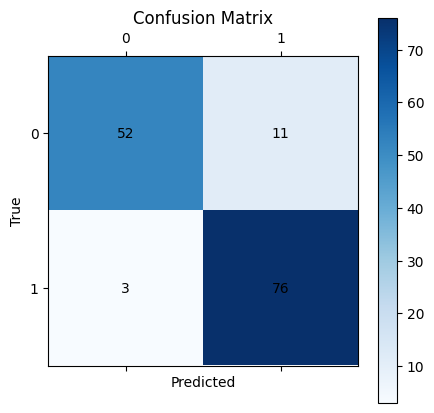

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# 성능 지표 계산
precision = precision_score(actual, origin_result, average='micro')
recall = recall_score(actual, origin_result, average='micro')
f1 = f1_score(actual, origin_result, average='micro')
accuracy = accuracy_score(actual, origin_result)

# 결과 출력
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1))
print('Accuracy: {:.5f}'.format(accuracy))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(np.array(actual).ravel(), np.array(origin_result).ravel())

fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', va='center', ha='center')

plt.show()

